# Labeled Faces in the Wild (LFW) experiment

In [156]:
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import tarfile
import os
import pandas as pd

# optionally download and unpack Labeled Faces in the Wild (170MB)
face_archive = 'lfw.tgz'
face_dir = 'lfw'
download_faces = False
unpack_faces = False

if download_faces:
    print ('Starting download ...')
    url = "http://vis-www.cs.umass.edu/lfw/" + face_archive
    response = requests.get(url)
    if response.status_code == 200:
        with open(face_archive, 'wb') as f:
            f.write(response.content)
            
    print ('Done.')
    
if unpack_faces:
    print ('Unpacking faces...')
    tf = tarfile.open(face_archive)
    tf.extractall()
    print ('Done.')

In [157]:
# normalize faces to this dimension
img_width = 120
img_height = 120

# Load the classifier
# Source: https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

def _extract_faces(img_path, scale_factor):
    # Read the input image
    img = cv2.imread(img_path)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=scale_factor, minSize=(80, 80), minNeighbors=4)
            
    # Extract the first face
    extracted_faces = []

    n_faces = len(faces)
    if n_faces == 0 or n_faces > 1:
        #print ('Wrong number of faces detected:', n_faces, ', path:', img_path, ', scale:', scale_factor)
        pass
        
    for (x, y, w, h) in faces:
        # take the first only
        extracted_face = img[y:y+h, x:x+w]
        extracted_faces.append(extracted_face)
        #print ('w:', w, 'h:', h)
        
    return extracted_faces

def _resize_image(img):
    img = cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
    return img

# adapt scale factor to extract exactly single face from the image
def extract_face(img_path):
    scale_factor = 1.05
    while scale_factor < 2.0:
        extracted_faces = _extract_faces(img_path, scale_factor)
        if (len(extracted_faces) == 1):
            # print ('Image:', img_path, 'scale:', scale_factor);
            return _resize_image(extracted_faces[0])
        scale_factor += 0.05
        
    #print ('Error, no face found:', img_path)
    return None

In [155]:
# Process data
person_list = os.listdir(path = face_dir)

all_person_extracted_faces = []
image_count = 0
errors_count = 0

print ('Processing images...')

for person in person_list:
    person_extracted_faces = []
    all_person_extracted_faces.append({'name' : person, 'faces' : person_extracted_faces})
    person_imgs = os.listdir(path = os.path.join(face_dir, person))
    for person_img in person_imgs:
        img_full_path = os.path.join(face_dir, person, person_img)
        extracted_face = extract_face(img_full_path)
        if extracted_face is not None:
            person_extracted_faces.append(extracted_face)
            image_count += 1
    if len(person_extracted_faces) == 0:
        errors_count += 1
        
print ('People found: ', len(person_list), ', images found:', image_count, ', errors:', errors_count)

Processing images...
People found:  5749 , images found: 13214 , errors: 6


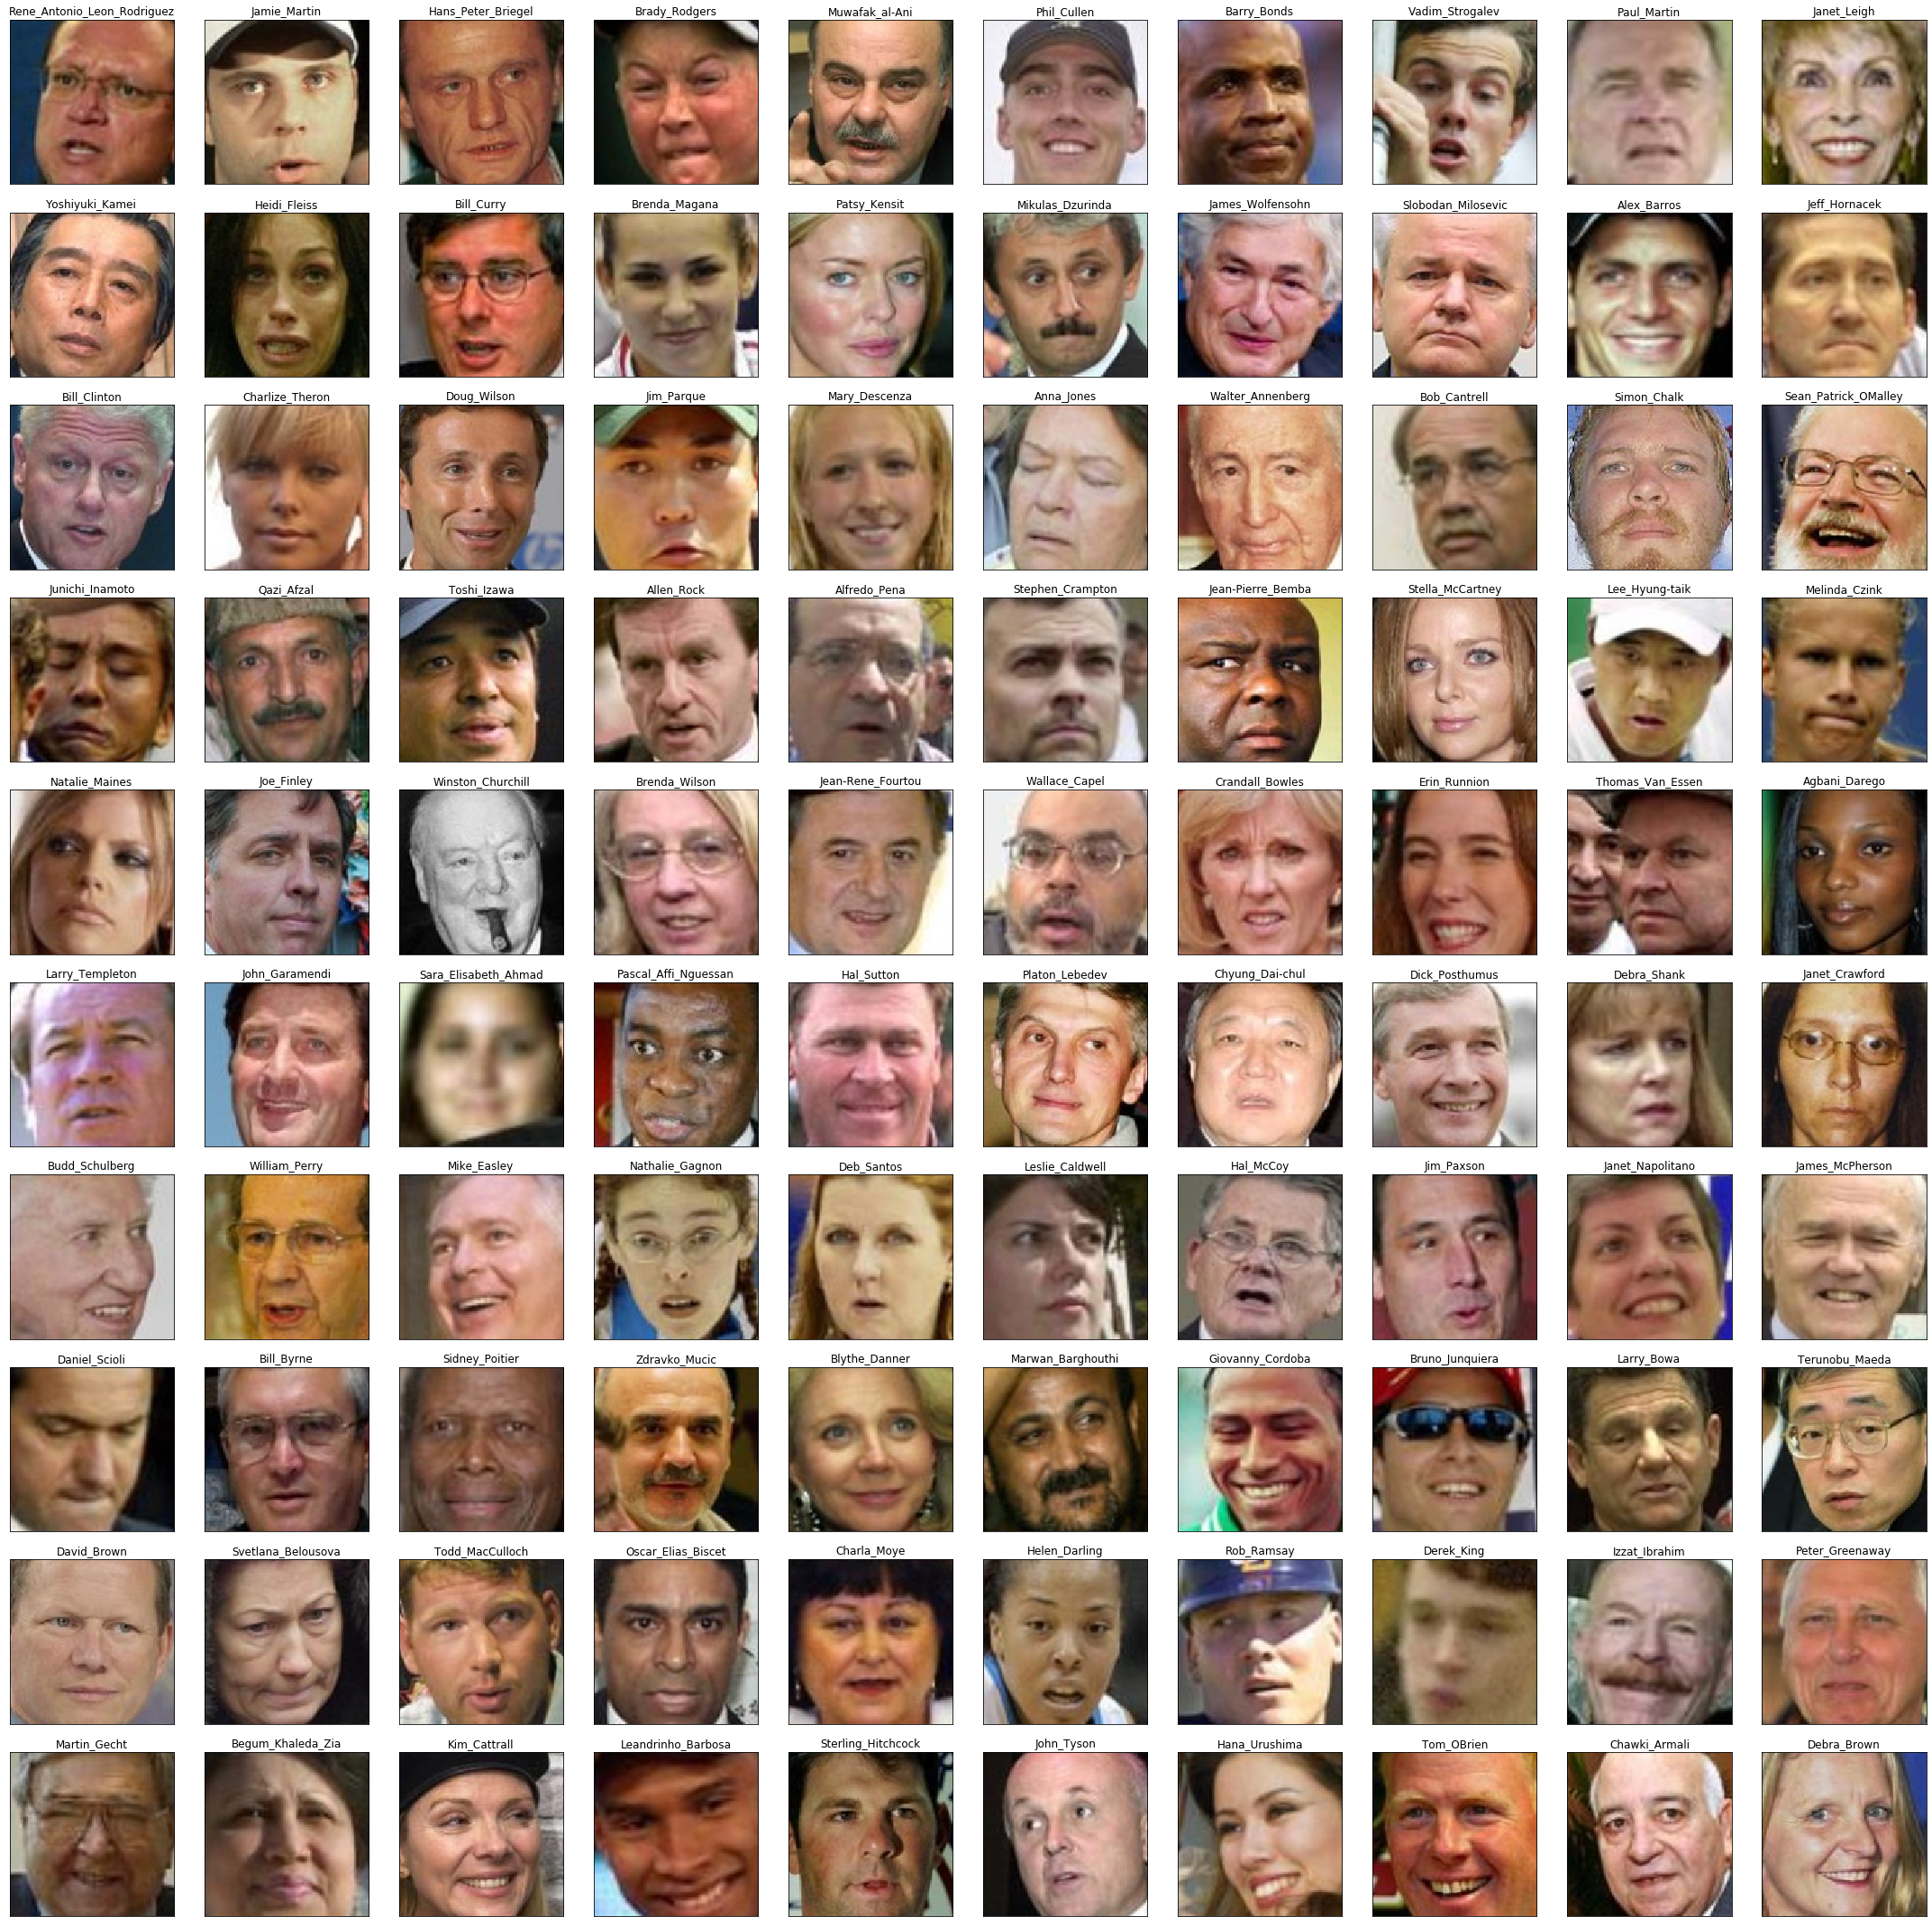

In [158]:
# show some extracted faces
import random

fig = plt.figure(figsize=(30, 30))
plt.axis("off")
for i in range(100):
    pos = random.randint(0, len(all_person_extracted_faces) - 1)
    person_with_faces = all_person_extracted_faces[pos]
    name = person_with_faces['name']
    faces = person_with_faces['faces']

    if len(faces) == 0:
        continue

    plt.subplot(10, 10, i+1)
    plt.tight_layout()
    plt.imshow(cv2.cvtColor(faces[0], cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(name)
    plt.xticks([])
    plt.yticks([])

In [130]:
# Keras (from TensorFlow) imports for building of neural network
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import image_data_format
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [131]:
# image shape
input_shape = (img_width, img_height, 3)
print('Input shape: ', input_shape)

# convert train output data into categories
num_classes = len(person_list)
num_samples = image_count

print('num_classes:', num_classes)
print('num_samples:', num_samples)

Input shape:  (120, 120, 3)
num_classes: 5749
num_samples: 13214


In [132]:
# prepare categories
Y_train = np.zeros(shape=(num_samples, num_classes), dtype=np.float32)

row_pos = 0 # image
col_pos = 0 # category = person

for person_with_faces in all_person_extracted_faces:
    faces = person_with_faces['faces']
    
    faces_count = len(faces)
    
    if faces_count > 0:
        for j in range(0, faces_count):
            Y_train[row_pos, col_pos] = 1.0
            row_pos += 1       
    
    # next person
    col_pos += 1

(13214, 5749)

In [133]:
# prepare train input data
x_train = []

for person_with_faces in all_person_extracted_faces:
    faces = person_with_faces['faces']
    
    faces_count = len(faces)
    if faces_count > 0:
        x_train.extend(faces)  
    
X_train = np.array(x_train)
print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)

X_train.shape: (13214, 120, 120, 3)
Y_train.shape: (13214, 5749)


In [134]:
# prepare generators of scaled images for learning process
batch_size = 32

train_img_data_gen = ImageDataGenerator(
    rescale=1.0 / 255)

train_generator = train_img_data_gen.flow(X_train, Y_train, batch_size=batch_size, shuffle=True)

In [135]:
# define CNN model for animal images classification
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

In [136]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 118, 118, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 57, 57, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [137]:
#model.load_weights('lfw1.h5')

In [140]:
# learn NN - tried 100 epochs
epochs = 2

history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs)

Epoch 1/2
412/412 [==============================] - 384s 932ms/step - loss: 0.1757 - accuracy: 0.9483
Epoch 2/2
412/412 [==============================] - 355s 862ms/step - loss: 0.1642 - accuracy: 0.9516


In [141]:
model.save_weights('lfw1.h5')

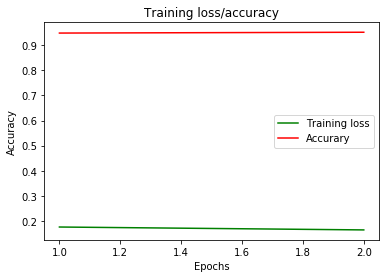

In [142]:
history_dict = history.history

loss_values = history_dict['loss']
accuracy_values = history_dict['accuracy']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b', label='Training loss', color='green')
plt.plot(epochs, accuracy_values, 'b', label='Accurary', color='red')

plt.title('Training loss/accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [148]:
# using one of train images (images from other sources are not working is currently not demonstrative)
extracted_face = extract_face('lfw\Pamela_Anderson\Pamela_Anderson_0004.jpg')
X_test = np.array(extracted_face)
X_test = np.expand_dims(X_test, axis=0)
X_test = X_test / 255.0
classes = model.predict_classes(X_test, batch_size=1, verbose=1)

Image: lfw\Pamela_Anderson\Pamela_Anderson_0004.jpg scale: 1.05
1/1 [==============================] - 0s 16ms/sample


In [149]:
predicted_person = all_person_extracted_faces[classes[0]]
predicted_person_name = predicted_person['name']
predicted_person_faces = predicted_person['faces']

print('It could be:', predicted_person_name)

It could be: Pamela_Anderson


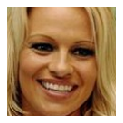

 ... could be ...


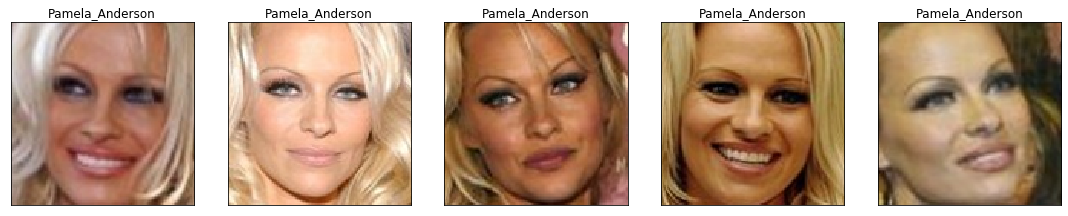

In [150]:
plt.figure(figsize=(2,2))
plt.axis("off")
plt.imshow(cv2.cvtColor(extracted_face, cv2.COLOR_BGR2RGB))
plt.show()

fig = plt.figure(figsize=(30, 30))
plt.axis("off")

print (' ... could be ...')

for i in range(len(predicted_person_faces)):
    plt.subplot(1, 10, i+1)
    plt.tight_layout()
    plt.imshow(cv2.cvtColor(predicted_person_faces[i], cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(predicted_person_name)
    plt.xticks([])
    plt.yticks([])
    if i == 9:
        break